In [1]:
# https://zenn.dev/google_cloud_jp/articles/fe964db69010db
# 【マルチモーダル対応エージェント】Agent Development Kit でメディアエージェントを作る

%pip install --upgrade --user \
    google-adk==1.2.1 \
    google-cloud-aiplatform==1.96.0

Note: you may need to restart the kernel to use updated packages.


In [2]:
import IPython
app = IPython.Application.instance()
_ = app.kernel.do_shutdown(True)

In [1]:
import json, os, re, uuid
import vertexai
from google.cloud import storage

from google import genai
from google.genai.types import (
    HttpOptions, GenerateContentConfig, Part, Content
)
from google.adk.agents.llm_agent import LlmAgent
from google.adk.artifacts import InMemoryArtifactService
from google.adk.memory.in_memory_memory_service import InMemoryMemoryService
from google.adk.runners import Runner
from google.adk.sessions import InMemorySessionService

[PROJECT_ID] = !gcloud config list --format 'value(core.project)'
LOCATION = 'us-central1'

vertexai.init(project=PROJECT_ID, location=LOCATION)

os.environ['GOOGLE_CLOUD_PROJECT'] = PROJECT_ID
os.environ['GOOGLE_CLOUD_LOCATION'] = LOCATION
os.environ['GOOGLE_GENAI_USE_VERTEXAI'] = 'True'

BUCKET_NAME = f'{PROJECT_ID}-adk-media'

In [2]:
!gsutil mb -b on -l {LOCATION} gs://{BUCKET_NAME}

Creating gs://zenn-test-457807-adk-media/...
ServiceException: 409 A Cloud Storage bucket named 'zenn-test-457807-adk-media' already exists. Try another name. Bucket names must be globally unique across all Google Cloud projects, including those outside of your organization.


In [3]:
photos = [
    'duck_and_truck.jpg', 'handwritten.jpg',
    'puppies.jpg', 'eiffel_tower.jpg',
]
photo_uris = ' '.join([f'gs://cloud-samples-data/vision/{item}' for item in photos])
!gsutil -m cp {photo_uris} gs://{BUCKET_NAME}/

pictures = [
    'https://blogger.googleusercontent.com/img/b/R29vZ2xl/AVvXsEhhuTPpp1ITtm1efWPA5Ke1V1uWz7-9lniIP0goxnFNgPlaiA33A6K_fX8bpQ8VGroVmrgkQl5pzfRZbwZNGXEAXnMvT3WIPOagILsEfLWOKkOv6jdmRwNCliI2XX9NiFoqLygN4_VNxFx2/s400/jitensya_papa_3nin2.png',
    'https://blogger.googleusercontent.com/img/b/R29vZ2xl/AVvXsEi6ZNtzo3MbPW5OkKXkD-tliX2CTkMEQpVBiwb6LocZF1MjaNP3Sm7rY7Uh1xfECAYojFT_FpsHZ7Nr7nshNqep8gfZQARoW5mJIswuIwa2AJxaIEiq87W76EVf3PyR160x9XCWM1P0bgyX/s450/jitensya_papa_3nin_dendo.png'
]
picture_urls = ' '.join([f'-O {item}' for item in pictures])
picture_files = ' '.join([item.split('/')[-1] for item in pictures])
!curl -L {picture_urls}
!gsutil cp {picture_files} gs://{BUCKET_NAME}/

Copying gs://cloud-samples-data/vision/duck_and_truck.jpg [Content-Type=image/jpeg]...
Copying gs://cloud-samples-data/vision/handwritten.jpg [Content-Type=image/jpeg]...
Copying gs://cloud-samples-data/vision/eiffel_tower.jpg [Content-Type=image/jpeg]...
Copying gs://cloud-samples-data/vision/puppies.jpg [Content-Type=image/jpeg]...
/ [4/4 files][900.6 KiB/900.6 KiB] 100% Done                                    
Operation completed over 4 objects/900.6 KiB.                                    
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  158k  100  158k    0     0   490k      0 --:--:-- --:--:-- --:--:--  490k
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  174k  100  174k    0     0   660k      0 --:--:-- --:--:-- --:--:--  660k
Copying file://jitensya_pap

In [4]:
def generate_response(system_instruction, contents,
                      response_schema, model='gemini-2.0-flash-001'):
    client = genai.Client(vertexai=True,
                          project=PROJECT_ID, location=LOCATION,
                          http_options=HttpOptions(api_version='v1'))
    response = client.models.generate_content(
        model=model,
        contents=contents,
        config=GenerateContentConfig(
            system_instruction=system_instruction,
            temperature=0.4,
            response_mime_type='application/json',
            response_schema=response_schema,
        )
    )
    return '\n'.join(
        [p.text for p in response.candidates[0].content.parts if p.text]
    )

In [5]:
system_instruction = '''
関西のお笑い芸人としてリクエストに答えてください。
'''
contents = 'ノリツッコミよろしく！'
response_schema = {
    "type": "object",
    "properties": {
        "nori": {"type": "string"},
        "tsukkomi": {"type": "string"},
    },
    "required": ["nori", "tsukkomi"],
}

response = generate_response(system_instruction, contents, response_schema)
print(response)

{
  "nori": "はい、毎度！今日はアホみたいな帽子かぶってきました～！",
  "tsukkomi": "誰がアホやねん！ていうか、それただの工事現場のヘルメットやないか！被る意味あるんかい！"
}


In [6]:
from PIL import Image
from io import BytesIO
import matplotlib.pyplot as plt

def display_image(blob_name, title, bucket_name=BUCKET_NAME):
    client = storage.Client()
    bucket = client.bucket(bucket_name)
    image_bytes = bucket.blob(blob_name).download_as_bytes()
    img = Image.open(BytesIO(image_bytes))
    fig, ax = plt.subplots(figsize=(4, 4))
    ax.imshow(img)
    ax.set_title(title, fontsize=10)
    ax.axis('off')

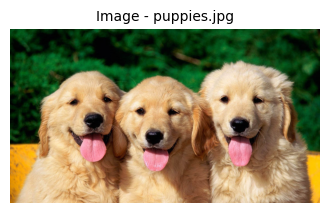

In [7]:
display_image('puppies.jpg', 'Image - puppies.jpg')

In [8]:
def list_image_files() -> dict:
    """Tool to list available image files for the user."""
    try:
        storage_client = storage.Client()
        bucket = storage_client.bucket(BUCKET_NAME)
        blobs = bucket.list_blobs()
        return {'files': [blob.name for blob in blobs if not blob.name.endswith('/')]}
    except Exception as e:
        return {'error': e}

In [9]:
response = list_image_files()
print(response)

{'files': ['duck_and_truck.jpg', 'eiffel_tower.jpg', 'handwritten.jpg', 'jitensya_papa_3nin2.png', 'jitensya_papa_3nin_dendo.png', 'puppies.jpg']}


In [10]:
def analyze_image(system_instruction: str, filename: str):
    """
    Tool to analyze an image using LLM.

    Args:
        system_instruction: Instruction to LLM on how to analyze an image
        filename: Filename of an image

    Returns:
        dict: A dictionary containing the plan with the following keys:
            filename: Filename of an image
            result: Result of the analysis
    """
    try:
        storage_client = storage.Client()
        bucket = storage_client.bucket(BUCKET_NAME)
        blob = bucket.blob(filename)
        blob.reload()
        mime_type = blob.content_type
        image = Part.from_uri(
            file_uri=f'gs://{BUCKET_NAME}/{filename}',
            mime_type=mime_type
        )

        parts = []
        parts.append(Part.from_text(text='[image]'))
        parts.append(image)
        contents = [Content(role='user', parts=parts)]
        response_schema = {
            "type": "object",
            "properties": {
                "filename": {"type": "string"},
                "result": {"type": "string"},
            },
            "required": ["filename", "result"],
        }
        result = generate_response(
            system_instruction, contents,
            response_schema, model='gemini-2.0-flash-001'
        )
        return json.loads(result)

    except Exception as e:
        return {
            'filename': filename,
            'result': f'An unexpected error occurred: {e}'
        }

In [11]:
response = analyze_image('何の画像か日本語で説明して。', 'puppies.jpg')
print(response)

{'filename': 'image.png', 'result': '3匹のゴールデンレトリバーの子犬が並んで座っていて、舌を出して笑っているように見えます。'}


In [12]:
class LocalApp:
    def __init__(self, agent, app_name='local_app', user_id='default_user'):
        self._agent = agent
        self._user_id = user_id
        self._app_name = app_name
        self._runner = Runner(
            app_name=self._app_name,
            agent=self._agent,
            artifact_service=InMemoryArtifactService(),
            session_service=InMemorySessionService(),
            memory_service=InMemoryMemoryService(),
        )
        self._session = None

    def _display_image(self, text, num_images):        
        def replace(match):
            nonlocal num_images
            num_images += 1
            return  f'## Displayed image [{num_images}] ##'
        
        pattern = '<image>(.+?)</image>'
        matches = re.findall(pattern, text)
        for c, filename in enumerate(matches):
            title = f'[{num_images+c+1}] {filename}'
            display_image(filename, title)
        text = re.sub(pattern, replace, text)
        return text, num_images

    async def stream(self, query):
        if not self._session:
            self._session = await self._runner.session_service.create_session(
                app_name=self._app_name,
                user_id=self._user_id,
                session_id=uuid.uuid4().hex,
            )
        content = Content(role='user', parts=[Part.from_text(text=query)])
        async_events = self._runner.run_async(
            user_id=self._user_id,
            session_id=self._session.id,
            new_message=content,
        )
        result = []
        num_images = 0
        async for event in async_events:
            if DEBUG:
                print(f'----\n{event}\n----')
            if (event.content and event.content.parts):
                response = ''
                for p in event.content.parts:
                    if not p.text:
                        continue
                    text, num_images = self._display_image(p.text, num_images)
                    response += f'[{event.author}]\n\n{text}\n'
                if response:
                    print(response)
                    result.append(response)
        return result

In [13]:
image_manager_agent = LlmAgent(
    name='image_manager_agent',
    model='gemini-2.0-flash',
    instruction='''
You are an agent that manages image files.
Output in Japanese without markdowns.

[conditions]
* Before working on tasks, explain what you will do in a short single sentence.
* Avoid mentioning tool names in your reply.
* Show underscore in filenames as "_" instead of "\_".
    - Good example: "my_file.png"
    - Bad example: "my\_file.png"

[tasks]

** List image files
    * You can get a list of image files with list_image_files().

** Display image
    * You can insert an image in your message by inserting a line "<image>_filename_</image>".
      Replace _filename_ with the filename of the image file. 
      Then the user will see the real image in that part.

** Analyze image
    * If you need to analyze an image, use analyze_image().
''',
    description='''
An agent that manage image files.
''',
    tools = [
        list_image_files,
        analyze_image,
    ]
)

In [14]:
client = LocalApp(image_manager_agent)
DEBUG = False

query = '''
画像ファイルは全部で何個ありますか？
10個以下ならファイル名をすべて表示して。
'''
_ = await client.stream(query)

[image_manager_agent]

画像ファイルの一覧を取得して、ファイル数が10個以下であればファイル名を表示します。



[image_manager_agent]

画像ファイルは6個あります。ファイル名は以下の通りです。
duck_and_truck.jpg
eiffel_tower.jpg
handwritten.jpg
jitensya_papa_3nin2.png
jitensya_papa_3nin_dendo.png
puppies.jpg




In [15]:
query = '''
それぞれの内容を簡単に短くまとめて、箇条書きで教えて。
'''
_ = await client.stream(query)

[image_manager_agent]

画像の内容を分析して、箇条書きで結果をお伝えします。



[image_manager_agent]

各画像の内容は以下の通りです。

*   duck_and_truck.jpg: 黄色いアヒルの人形とカラフルな玩具のダンプカーが白い背景に置かれている画像です。
*   eiffel_tower.jpg: パリのエッフェル塔が曇りの日に撮影された画像で、前景にはセーヌ川が写っています。
*   handwritten.jpg: Google Cloud Platform での手書き文字認識のデモンストレーションとして、手書きのメッセージが書かれた画像です。
*   jitensya_papa_3nin2.png: 自転車に父親と子供2人が乗っている画像です。
*   jitensya_papa_3nin_dendo.png: 電動自転車に父親と子供2人が乗っていて、子供たちはヘルメットを着用しています。
*   puppies.jpg: 3匹のゴールデンレトリバーの子犬が並んで座り、舌を出して息を切らしている画像です。




[image_manager_agent]

手書きのメッセージの画像を表示し、書かれている内容をお伝えします。

## Displayed image [1] ##



[image_manager_agent]

画像に書かれている内容は以下の通りです。

This is a handwritten message
to use with Google Cloud
Platform, To demonstrate the capabilities
of the Cloud Vision API to detect
handwritten text.




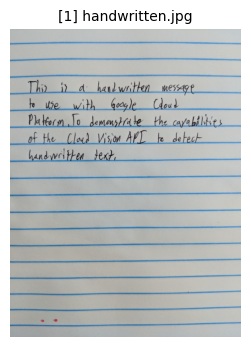

In [16]:
query = '''
手書きのメッセージの画像を表示して。
なんて書いてあるか教えて。
'''
_ = await client.stream(query)


[image_manager_agent]

子供が喜びそうなキュートな写真を2つ選び、キュートなタイトルを付けて表示します。

子供が喜びそうな写真として、子犬の写真(puppies.jpg)と、自転車に乗った親子の写真(jitensya_papa_3nin_dendo.png)を選びます。

*   **puppies.jpg:** タイトル： 「なかよし わんこ３兄弟」

## Displayed image [1] ##

*   **jitensya_papa_3nin_dendo.png:** タイトル：「おでかけ しゅっぱつ しんこう！」

## Displayed image [2] ##




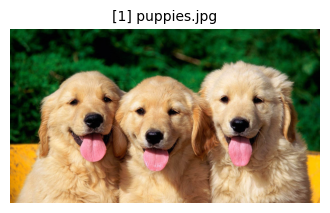

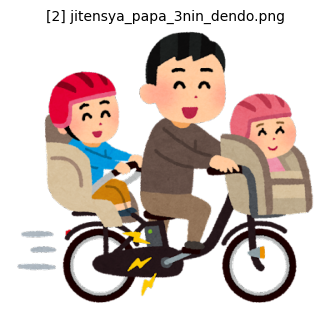

In [17]:
query = '''
子供が喜ぶキュートな写真はどれかな？
２つ選んで表示して、それぞれにキュートなタイトルを付けて。
'''
_ = await client.stream(query)

[image_manager_agent]

イラスト画像をすべて表示します。

jitensya_papa_3nin2.png

## Displayed image [1] ##

jitensya_papa_3nin_dendo.png

## Displayed image [2] ##




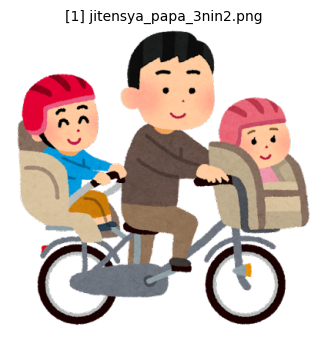

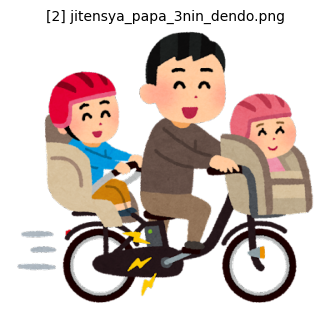

In [18]:
query = '''
イラスト画像をすべて表示してください。
'''
_ = await client.stream(query)

In [19]:
query = '''
間違い探しです。先ほどの２つの画像にはどのような違いがありますか？
一言でどうぞ！
'''
_ = await client.stream(query)

[image_manager_agent]

2つの画像の違いについて説明します。



[image_manager_agent]

自転車が電動かどうか、です！




In [20]:
query = '''
なぜ電動自転車だとわかるのですか？
'''
_ = await client.stream(query)

[image_manager_agent]

電動自転車だとわかる理由を説明します。



[image_manager_agent]

画像分析の結果に「electric bicycle（電動自転車）」と明記されているからです。




[image_manager_agent]

2つのイラスト画像を使った2コマ漫画を作成します。

**1コマ目:**

## Displayed image [1] ##

メッセージ: 「今日も頑張ってペダルを漕ぐぞ！…あれ？なんか進むのが遅いような…」

**2コマ目:**

## Displayed image [2] ##

メッセージ: 「電動アシストON！…最初から押しとけばよかった〜！」




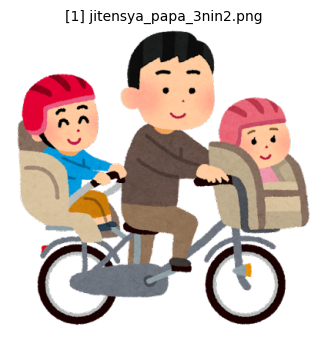

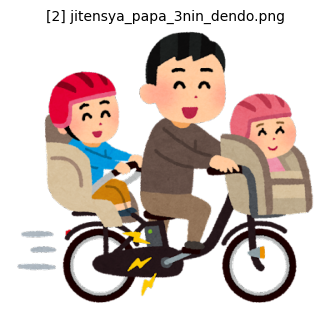

In [21]:
query = '''
この２つのイラスト画像を使った２コマ漫画を作ります。
１つのコマは、１つの画像とそれに付随するメッセージで構成されます。
２つのコマを連続して読むことで、笑えるストーリーになります。
出来上がったら、画像とメッセージを組み合わせた２コマ漫画として表示してください。
'''
_ = await client.stream(query)